# Evidence 1 - Supervised learning

Paulina Leal Mosqueda, A01659576

Santiago Nava Figueroa, A01174557

Natalie Wilske, A01764862



In [62]:
import sys
assert sys.version_info >= (3, 7)

import pandas as pd
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [63]:

from pathlib import Path
IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)



# Import dataset and explore it

In [64]:
import openml
import pandas as pd

# Get Dataset from OPENML
dataset = openml.datasets.get_dataset(23)


df, *_ = dataset.get_data()

# Get features as X
X = df.drop('Contraceptive_method_used',axis=1)


# Get class as y
y = df['Contraceptive_method_used']


In [65]:
X

,Wifes_age,Wifes_education,Husbands_education,Number_of_children_ever_born,Wifes_religion,Wifes_now_working%3F,Husbands_occupation,Standard-of-living_index,Media_exposure
0,24,2,3,3,1,1,2,3,0
1,45,1,3,10,1,1,3,4,0
2,43,2,3,7,1,1,3,4,0
3,42,3,2,9,1,1,3,3,0
4,36,3,3,8,1,1,3,2,0
...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0
1469,33,4,4,3,1,1,1,4,0
1470,39,3,3,8,1,0,1,4,0
1471,33,3,3,4,1,0,2,2,0


In [66]:
y.value_counts()

Contraceptive_method_used
1    629
3    511
2    333
Name: count, dtype: int64

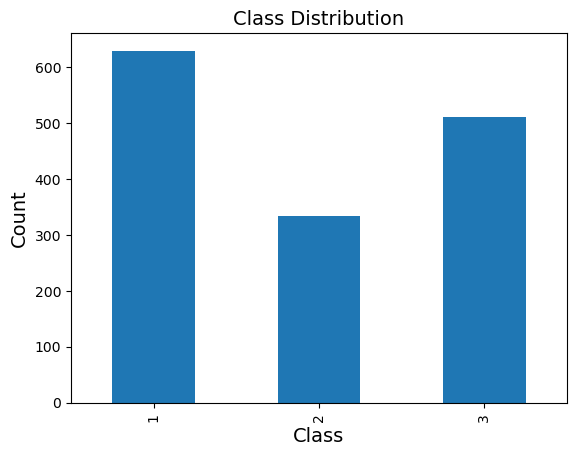

In [67]:
import matplotlib.pyplot as plt

y.value_counts().sort_index().plot(kind='bar')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')

plt.show()

In [68]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Wifes_age                     1473 non-null   uint8   
 1   Wifes_education               1473 non-null   category
 2   Husbands_education            1473 non-null   category
 3   Number_of_children_ever_born  1473 non-null   uint8   
 4   Wifes_religion                1473 non-null   category
 5   Wifes_now_working%3F          1473 non-null   category
 6   Husbands_occupation           1473 non-null   category
 7   Standard-of-living_index      1473 non-null   category
 8   Media_exposure                1473 non-null   category
dtypes: category(7), uint8(2)
memory usage: 14.2 KB


In [69]:
X.describe()

,Wifes_age,Number_of_children_ever_born
count,1473.000000,1473.000000
mean,32.538357,3.261371
std,8.227245,2.358549
min,16.000000,0.000000
25%,26.000000,1.000000
50%,32.000000,3.000000
75%,39.000000,4.000000
max,49.000000,16.000000


# Description of Dataset
The dataset is focused in predicting contraceptive method choice (no use, long-term methods, or short-term methods) of a woman based on her demographic and socio-economic characteristics. The samples come from a subset of the 1987 National Indonesia Contraceptive Prevalence Survey and they contain married women who were either not pregnant or do not know if they were at the time of interview.

It has 1473 instances with 10 features including the class. Information of the features:

* Wife's age (16-49): numerical
* Wife's education (categorical) 1=low, 2, 3, 4=high
* Husband's education (categorical) 1=low, 2, 3, 4=high
* Number of children ever born (0-16): numerical
* Wife's religion (binary) 0=Non-Islam, 1=Islam
* Wife's now working? (binary) 0=Yes, 1=No
* Husband's occupation (categorical) 1, 2, 3, 4
* Standard-of-living index (categorical) 1=low, 2, 3, 4=high
* Media exposure (binary) 0=Good, 1=Not good
* Contraceptive method used (class attribute) 1=No-use 2=Long-term 3=Short-term

(OpenMl, n.d.)

In this case, the categorical features are set as nominal, but if we observe there are some that may seem as ordinal because they use a low to high scale. For that reason, one of the aims is to treat those features as ordinal and the other is to treat it as nominal. After doing this, the performance will be evaluated to assess which option is the best. There are also no Nan values in the dataset.

As we can see above the classes are a bit unbalanced, because class 1 is 42.7% of the dataset, while class 2 is 34.69% and class 3 is 22.60%. So even if they don't have the same number of samples, they are still close to each other.

# Compare results with OneHotEncoder for the categorical variables
We will use OneHotEncoder for this because it allows us to separate the variables in a way in which we don't give more weight to a value. Since, we're gonna test it with default decisions trees, there is no need in scaling the numeric variables.

# Default Decision Tree
**OneHotEncoder just for Husbands_occupation**

In [70]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder



# Only convert categorical feature of Husband's occupation.
categorical_features = ['Husbands_occupation']
numeric_features = ["Wifes_age", "Number_of_children_ever_born"]  
binary_features = ["Wifes_religion", "Wifes_now_working%3F", "Media_exposure"]
ordinal_features = ["Wifes_education", "Husbands_education", "Standard-of-living_index"]



# Create pipline for categorical vairables (OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

#OrdinalEncoder
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

#Preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ('binary', 'passthrough', binary_features),
        ('ordinal', ordinal_transformer, ordinal_features),
        ('num', 'passthrough', numeric_features)
    ]
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

# Split dataset

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Results for Default Tree 
**OneHotEncoder just for Husbands_occupation**

In [72]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("First example with 'Husbands_occupation':")
print(f"Tree depth: {pipeline.named_steps['classifier'].get_depth()}")
print(classification_report(y_test, y_pred))

First example with 'Husbands_occupation':
Tree depth: 23
              precision    recall  f1-score   support

           1       0.65      0.63      0.64       130
           2       0.43      0.39      0.41        71
           3       0.39      0.43      0.41        94

    accuracy                           0.51       295
   macro avg       0.49      0.48      0.49       295
weighted avg       0.51      0.51      0.51       295



In [73]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
print(feature_names)

['cat__Husbands_occupation_2' 'cat__Husbands_occupation_3'
 'cat__Husbands_occupation_4' 'binary__Wifes_religion'
 'binary__Wifes_now_working%3F' 'binary__Media_exposure'
 'ordinal__Wifes_education' 'ordinal__Husbands_education'
 'ordinal__Standard-of-living_index' 'num__Wifes_age'
 'num__Number_of_children_ever_born']


# Default Tree 
**OneHotEncoder for all categorical variables****

In [74]:

categorical_features2 = ["Wifes_education", 'Husbands_occupation', "Husbands_education", "Standard-of-living_index"]
numeric_features = ["Wifes_age", "Number_of_children_ever_born"]  
binary_features = ["Wifes_religion", "Wifes_now_working%3F", "Media_exposure"]


categorical_transformer2 = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])


preprocessor2 = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer2, categorical_features2),
        ('binary', 'passthrough', binary_features),
        ('num', 'passthrough', numeric_features)
    ]
)

pipeline2 = Pipeline([
    ("preprocessor", preprocessor2),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

pipeline2.fit(X_train, y_train)
y_pred = pipeline2.predict(X_test)

print(f"Tree depth: {pipeline2.named_steps['classifier'].get_depth()}")
print(classification_report(y_test, y_pred))

Tree depth: 20
              precision    recall  f1-score   support

           1       0.61      0.62      0.61       130
           2       0.41      0.39      0.40        71
           3       0.46      0.46      0.46        94

    accuracy                           0.51       295
   macro avg       0.49      0.49      0.49       295
weighted avg       0.51      0.51      0.51       295



In [75]:
from sklearn import set_config
set_config(transform_output='pandas')  # For easier inspection (scikit-learn >=1.2)

X_train_transformed = pipeline.named_steps['preprocessor'].fit_transform(X_train)
print(X_train_transformed.shape)

print("Train accuracy:", pipeline.score(X_train, y_train))
print("Test accuracy:", pipeline.score(X_test, y_test))

(1178, 11)
Train accuracy: 0.9584040747028862
Test accuracy: 0.5084745762711864


Therefore, the results with only the best results are obtained by transforming all the categorical features. It is now possible to create a fine-tuned decision tree by converting the categorical features using OneHotEncoder. Since the maximum depth of the default tree was 20, we'll set the height to 30 to have a margin of error.

Now, we need to decide the performance measure that we'll use. In this case, accuracy is not the best option because the decision will give more weight to class 1, given the initial class distribution that we saw first, which was moderately unbalanced. If we choose precision, we would overlook some of the classes. Thus, the model loses information about the woman's choice based on her characteristics. On the other hand, if we only use recall, the model may misclassify some classes, which would generate false conclusions and ultimately affect the interpretation of how women choose their contraceptive method. Therefore, in this case, the performance measure will be the F1-score because it is the harmonic mean of precision and recall, which means that we will consider both measures. 

Since the dataset is slightly unbalanced we'll use stratified folds, so that the folds contain a representative ratio of each class.

# Preprocessing

In [76]:
# Convert all categorical with One Hot Encoder
categorical_features = ["Wifes_education", 'Husbands_occupation', "Husbands_education", "Standard-of-living_index"]
numeric_features = ["Wifes_age", "Number_of_children_ever_born"]  
binary_features = ["Wifes_religion", "Wifes_now_working%3F", "Media_exposure"]


# Create pipline for categorical vairables (OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

#OrdinalEncoder
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

#Preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ('binary', 'passthrough', binary_features),
        ('num', 'passthrough', numeric_features)
    ]
)


# Decision Tree

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report


cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=10, random_state=42)



param_grid = {
    'classifier__max_depth': [None, 5, 10, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_weighted',  
    cv=cv,
    n_jobs=-1 
)

grid_search.fit(X_train, y_train)

best_tree = grid_search.best_estimator_


y_pred = best_tree.predict(X_test)

print(classification_report(y_test, y_pred))
print("Best parameters:", grid_search.best_params_)
print("Best weighted F1 score:", grid_search.best_score_)

              precision    recall  f1-score   support

           1       0.73      0.54      0.62       130
           2       0.56      0.42      0.48        71
           3       0.44      0.68      0.54        94

    accuracy                           0.56       295
   macro avg       0.58      0.55      0.55       295
weighted avg       0.60      0.56      0.56       295

Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Best weighted F1 score: 0.5528766823464109


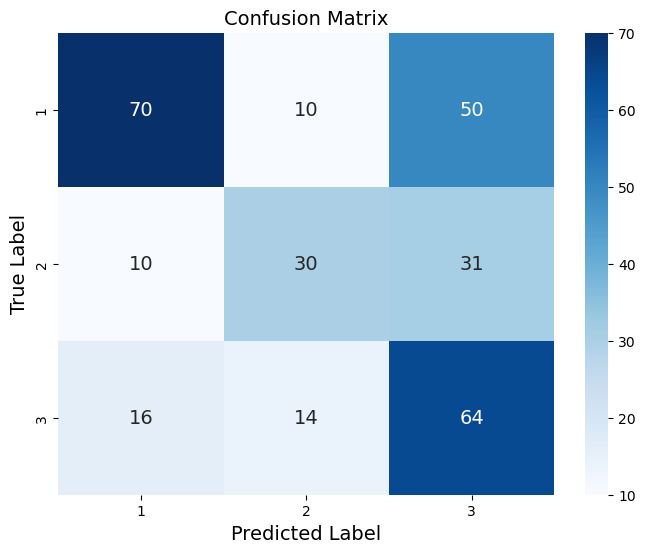

0.5591663379174138


In [102]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, f1_score


y_pred = best_tree.predict(X_test)


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["1", "2", "3"], 
            yticklabels=["1", "2", "3"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print ( f1_score(y_test, y_pred, average='weighted') )

The decision tree has better results for class 1 because there were more instances in comparison to the others. However, there are 50 instances that are being classified as false positives since they belonged to class 3. Moreover, class 2 has lower true positives, which means that the model struggles to identify the women who use long-term contraceptives. In this case, the model also has more false positives than class 3. This suggests that the model is producing several false positives that belonged to class 3. Moreover, most of the instances for class 3 were correctly classified, although there are some exceptions. In general, the decision tree performs better for class one.

In [79]:
best_dt = best_tree.named_steps['classifier']
feature_names = best_tree.named_steps['preprocessor'].get_feature_names_out()


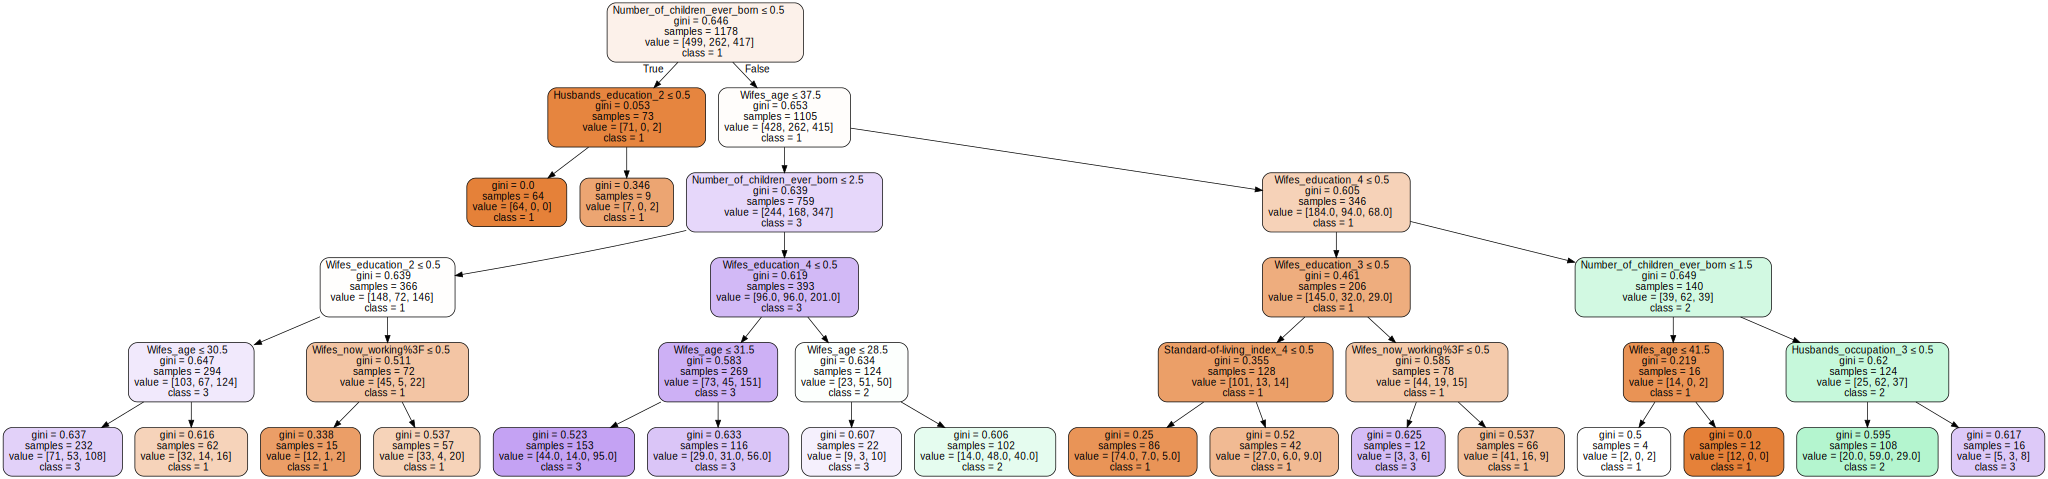

In [80]:
from sklearn.tree import export_graphviz
from graphviz import Source


feature_names = best_tree.named_steps['preprocessor'].get_feature_names_out()

dot_path = IMAGES_PATH / "best_tree.dot"


clean_feature_names = []
for name in feature_names:
    clean_name = name.split('__')[-1]
    clean_feature_names.append(clean_name)



export_graphviz(
    best_dt,
    out_file=str(dot_path),
    feature_names=clean_feature_names,  
    class_names=["1", "2", "3"],
    rounded=True,
    filled=True,
    special_characters=True,
)


Source.from_file(dot_path)

We chose 20 splits for RepeatedStratifiedKFold because this combination gave the best result for the F1 score after trying different values. Moreover, the maximum depth for the parameter of the GridSearch was 30 because the default tree had a maximum height of 23. We used a weighted F1 score to balance precision and recall, ensuring the dataset is representative and avoiding bias towards class one. This ensures that all targets are taken into account and that the minority classes are not being overshadowed. 

The results indicate that the model continues to favour class one, achieving the highest scores across all performance measures. This bias may come from the original dataset's limit size of 1473 samples and the restricted number of features, which totals only 10, including the class label.

# KNeighborsClassifier
Paulina Leal

It's a non-parametric supervised learning classifier, which uses proximity to make classifications it works by the assumption that similar points can be found near one another. The value of k represents how many neighbors will be checked to determine the classification of a specific point. It is usually recommended to use odd numbers, to avoid ties in classification. 



| Advantages                                | Disadvantages                                |
|-------------------------------------------|---------------------------------------------|
| Adapts easily: the algorithm adjusts to account for any new data. | Data does not scale well: time-consuming, requires memory and storage. |
| Few hyperparameters: only needs k value and distance metric. | Doesn’t perform well with high-dimensional data inputs. |
| Easy to implement.                        | Prone to overfitting: lower k overfits, higher k smoothes data. |
| Versatile: works for classification and regression. | High k values can underfit data. |

(IBM, s.f.)


This classifier is commonly seen as a simple algorithm because it only need two parameters to actually work, k-values and distance. It is also, called a lazy algorithm because it stores the dataset and at the time of classification is performs an action (it doesn't learn immeditatly). There are several statistical methods to choose the k value, such as: cross-validation (finds best value of k bu using k-folds), elbow method, odd values. Moreover, the metric of distances that can be used are: euclidean distance (straigh line distance), Manhattan distance (total distance it takes to travel by moving horizontally and vertically) and Minkowski that is able to represent either Euclidian (2) or Manhattan (1)depending on the value of p. After selecting this two measures, the algorithm uses a voting technique, to classify a data point into a category (GeeksforGeeks, 2025).

In [81]:
X_train.describe()

,Wifes_age,Number_of_children_ever_born
count,1178.000000,1178.000000
mean,32.829372,3.345501
std,8.332956,2.425505
min,16.000000,0.000000
25%,26.000000,2.000000
50%,32.000000,3.000000
75%,39.000000,5.000000
max,49.000000,16.000000


# Preprocessing for this KNeighborsClassifier.

Since KNN is a classifier that uses distance as one of it's parameters, it will be nessecary to scale the numeric features, because otherwise the model will be biased towards the ones that have heigher values, which in this case correspond to the feature of wife's age. Moreover, the categorical variables will be treated as they were stated before, so that the results between models use the same criteria. Moreover, in this case the dataset doesn't have any NaN values, so the only preprocessing will be done as before. It is also important to mention, that to avoid loosing information from the original dataset, the binary features will be set as passthrough inside the pipline, because there will be no change to those variables, since they are already in zeros and ones. This will allow the model to give a certain importance to the instances depending on the order that they have. 


In [82]:
# Convert all categorical with One Hot Encoder
categorical_features = ["Wifes_education", 'Husbands_occupation', "Husbands_education", "Standard-of-living_index"]
numeric_features = ["Wifes_age", "Number_of_children_ever_born"]  
binary_features = ["Wifes_religion", "Wifes_now_working%3F", "Media_exposure"]


# Create pipline for categorical vairables (OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Scale numeric variables
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

#OrdinalEncoder
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

#Preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ('binary', 'passthrough', binary_features),
        ('num', numeric_transformer, numeric_features),
    ]
)


In [83]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold


knn_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

param_grid = {
    'classifier__n_neighbors': list(range(1, 40)),
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}

#cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

grid_search_knn = GridSearchCV(estimator=knn_model,param_grid=param_grid,cv=cv,scoring='f1_weighted',n_jobs=-1)


grid_search_knn.fit(X_train, y_train)


best_knn = grid_search_knn.best_estimator_

y_pred_knn = best_knn.predict(X_test)


print("Best parameters:", grid_search_knn.best_params_)
print("\nClassification report on test set:")
print(classification_report(y_test, y_pred_knn))
print("Test f1_score:", f1_score(y_test, y_pred_knn, average='weighted'))

Best parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 37, 'classifier__p': 1, 'classifier__weights': 'uniform'}

Classification report on test set:
              precision    recall  f1-score   support

           1       0.67      0.66      0.67       130
           2       0.57      0.44      0.50        71
           3       0.50      0.61      0.55        94

    accuracy                           0.59       295
   macro avg       0.58      0.57      0.57       295
weighted avg       0.59      0.59      0.59       295

Test f1_score: 0.5886467207074428


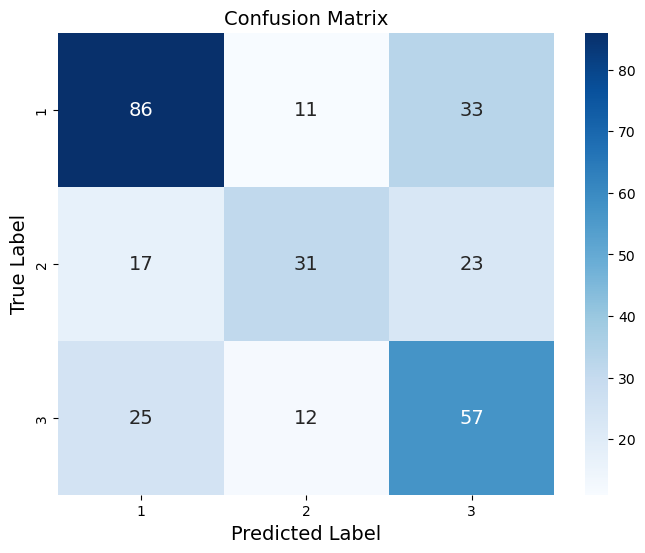

In [84]:
cm = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["1", "2", "3"], 
            yticklabels=["1", "2", "3"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

The confusion matrix helps to visualize how well instances are classified, allowing us to understand the model's performance. In that regard, we can see how class one had the best results since 85 instances were classified correctly as women who don't use contraceptives. In contrast, class 2 (long-term) failed to effectively classify women's choices, as a there were some instances that were incorrectly assigned to this class when they belonged to class 3. Hence, the model doesn't perform well for class 2. Finally, class three had 57 true positive values. Therefore, the model performs best when it classifies the class one. However, it is also important to understand if there was underfitting in the model because the number of k-values was 37 (when the k-value is very high, it tends to underfit).

In [85]:
# Results from training and testing
# See if there's any overfitting

# Train the model with X_train
y_train_pred_knn = best_knn.predict(X_train)


print("\nClassification report on training set:")
print(classification_report(y_train, y_train_pred_knn))

# F1 scores for comparison
train_f1 = f1_score(y_train, y_train_pred_knn, average='weighted')
test_f1 = f1_score(y_test, y_pred_knn, average='weighted')

print(f"Train f1_score: {train_f1}")
print(f"Test  f1_score: {test_f1}")




Classification report on training set:
              precision    recall  f1-score   support

           1       0.64      0.63      0.63       499
           2       0.50      0.39      0.44       262
           3       0.51      0.59      0.54       417

    accuracy                           0.56      1178
   macro avg       0.55      0.53      0.54      1178
weighted avg       0.56      0.56      0.56      1178

Train f1_score: 0.5580821185952497
Test  f1_score: 0.5886467207074428


In the case of this dataset, KNeighborsClassifier is a suitable classifier because it can handle well-preprocessed mixed instances, including numerical, binary and nominal. Another thing to note is that KNN tends to behave adequately for relatively small datasets, and it specialises in multiclass classification, which is the case in this project (only 1473 instances). Since KNeighborsClassifier looks for the minimum distance, it tends to perform well when it classifies the targets based on their features, which, in this case, will allow us to understand more about the characteristics that women have based on their contraceptive choices. However, we noticed that there are a total of 626 women who don't use contraceptive methods, while there are 333 who use them for the long term, which might cause the model to underperform in some classes. Thus, to make all classes more representative of the dataset, we implemented both StratifiedKfolds and RepeatedStratifiedKfolds so that the minority class could be treated with more weight.  That is also the reason why we preferred to use a weighted F1 score and because it allows us to ensure that the women's contraceptive choice is correctly classified. As stated before, accuracy is not a recommended measure because the data is a bit unbalanced. Moreover, using precision would mean we ignore false negatives, which is important because missing a woman who uses contraceptives could lead to misinformed conclusions. Similarly, relying only on recall might overpredict a class, thus it would be misclassifying their choice. 

To set the range of k values, it was necessary to try several ranges and observe which one got the best F1 score overall. Initially, the range went from 1-20, where the best result for StratifiedKFold was of 0.57 (with 13 k-values) and the best one for RepeatedStratifiedKFold was 0.55 with 18 k-values. We then increased the interval to 1-30, where the best result for StratifiedKFold was of 0.56 (with 13-k values) and the one of RepeatedStratifiedKFold was of 0.55 with 18 k-values. Then, the range was changed to 1-40, and the results improved by getting a 0.58 F1 score with 37 values, which helps to smooth the results. If we incremented the number of k neighbours, the result was always the same, so we decided to stay within the range of 1-40. To find the metric of distance, we used GridSearch, tried all of the possible metrics and chose the one that gave the highest weighted F1 score. To perform cross-validation, we took into account the fact that the data is not perfectly balanced, and we decided to try both StratifiedKFold and RepeatedStratifiedKFold. The values of the number of splits were changed several times for both of them until we got the best result, which was 10 with RepeatedStratifiedKFold. 


The best model for KNN has an F1 score of 0.58, while the score of the training set was 0.55. Therefore, the model didn't overfit, nor did it underfit, given that the results of the test and training were reason similar. Although, it is important to note that the test score was slighlty heigher than the train score, which is a consequence of the small dataset. Moreover, even if we changed the hyperparameters, the results were still lower than 0.58. This is mainly because there were not enough features, and the dataset was small. Therefore, the model didn't have enough information to learn from, causing it to have low results. 

Furthermore, if we observe the results of class 1 (no-use), we can see that it was the class that was best classified. Hence it had higher scores for all performance measures. This has to do with the fact that it represented the class with the most frequent occurrences in the original dataset. It is also possible to observe that class 3 (short-term) had 55% of the F1 score, while class 2 (long-term) had 50%, which suggests that the model struggled the most when it tried to classify class 2. However, the fact that class one (no-use), was the one that is best classified suggests that it is possible to find some insights about the characteristics of the women that were classified in this class, which would help to understand the reason why some women in India are opting against the use of contraceptive methods.

# Logistic Regression

By Santiago Nava

Logistic regression is a probabilistic model used for classification tasks. Unlike linear regression, which aims to predict a continuous variable, logistic regression estimates the probability that an observation belongs to a given class. In its simplest form, it is used for binary classification, although it can be extended to multiclass problems using strategies such as One-vs-Rest or the multinomial formulation.

Formally, the model is based on a linear combination of the independent variables, expressed as $$ z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p $$ where
𝛽
0
is the intercept and
𝛽
𝑖
the coefficients associated with the predictor variables
𝑥
𝑖
.

Since the objective is to model a probability, a logistic link function (the sigmoid) is applied, restricting the output range to the interval (0, 1): $$ P(Y=1 \mid X) = \frac{1}{1 + e^{-z}} = \sigma(z) $$ This expression can be interpreted as the conditional probability that the dependent variable
𝑌
takes the value 1, given the predictors
𝑋
. The final class assignment is typically done through a threshold, commonly 0.5.

To extend logistic regression to multiple classes, the softmax function is used, which generalizes the sigmoid for
𝐾
possible classes. In that case, the probability of class membership
𝑘
is defined as $$ P(Y=k \mid X) = \frac{e{z_k}}{\sum_{j=1}K e^{z_j}} $$ where each
𝑧
𝑘
corresponds to a linear combination of the predictors specific to class
𝑘
.

The model is trained by maximizing the likelihood of the observed data set, which is equivalent to minimizing the log-loss function using optimization techniques such as gradient descent or other more efficient numerical methods such as quasi-Newton (e.g., BFGS or L-BFGS).

The model can incorporate (L1, L2) regularization to avoid overfitting and can accommodate adjustments for class imbalance through weights proportional to the inverse frequency of each class.

## Advantages:
* Interpretability:

Logistic regression coefficients indicate the direction and magnitude of the relationship between the predictor variables and the probability of the target class, facilitating its interpretation in analytical contexts.

* Computational Efficiency:

Being a linear model, its training is fast even with moderate-sized data sets, thanks to optimized algorithms such as gradient descent or quasi-Newton methods (e.g., L-BFGS).

* Built-in Regularization:

Scikit-learn allows applying L1 (Lasso) and L2 (Ridge) penalties to prevent overfitting and improve generalization, even in cases of high dimensionality.

## Disadvantages
Linearity Assumption:

Assumes a linear relationship between features and the log-odds of the target class. If the data exhibits complex nonlinear patterns, the model will perform suboptimally unless feature transformations (e.g., polynomials) are applied.

Problems with Imbalanced Classes:

Tends to favor the majority class in imbalanced datasets unless hyperparameters such as class_weight are tuned or resampling techniques (e.g., SMOTE) are employed.

Preprocessing Dependency:

Requires feature scaling (e.g., StandardScaler) for regularization to work properly, as variables at different scales can bias the coefficients.


## Prepocessing for Logistic regression

Since logistic regression is a model that assumes a linear relationship (or multilinear in this case for various z), preprocessing must be done for categorical variables and also scaling for numerical variables.

In [86]:
# Convert all categorical with One Hot Encoder
categorical_features = ["Wifes_education", 'Husbands_occupation', "Husbands_education", "Standard-of-living_index"]
numeric_features = ["Wifes_age", "Number_of_children_ever_born"]  
binary_features = ["Wifes_religion", "Wifes_now_working%3F", "Media_exposure"]


# Create pipline for categorical vairables (OneHotEncoder)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Scale numeric variables
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

#OrdinalEncoder
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

#Preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ('binary',ordinal_transformer, binary_features),
        ('num', numeric_transformer, numeric_features),
    ]
)

In [87]:
X_train_processed = preprocessor.fit_transform(X_train)
X_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1178 entries, 998 to 1126
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   cat__Wifes_education_2             1178 non-null   float64
 1   cat__Wifes_education_3             1178 non-null   float64
 2   cat__Wifes_education_4             1178 non-null   float64
 3   cat__Husbands_occupation_2         1178 non-null   float64
 4   cat__Husbands_occupation_3         1178 non-null   float64
 5   cat__Husbands_occupation_4         1178 non-null   float64
 6   cat__Husbands_education_2          1178 non-null   float64
 7   cat__Husbands_education_3          1178 non-null   float64
 8   cat__Husbands_education_4          1178 non-null   float64
 9   cat__Standard-of-living_index_2    1178 non-null   float64
 10  cat__Standard-of-living_index_3    1178 non-null   float64
 11  cat__Standard-of-living_index_4    1178 non-null   float64


5285.05s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5285.23s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
/home/santiagonavafigueroa/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From 

Best parameters: {'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__multi_class': 'multinomial', 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}

Classification report on test set:
              precision    recall  f1-score   support

           1       0.71      0.55      0.62       130
           2       0.47      0.58      0.52        71
           3       0.47      0.53      0.50        94

    accuracy                           0.55       295
   macro avg       0.55      0.55      0.55       295
weighted avg       0.58      0.55      0.56       295



5361.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


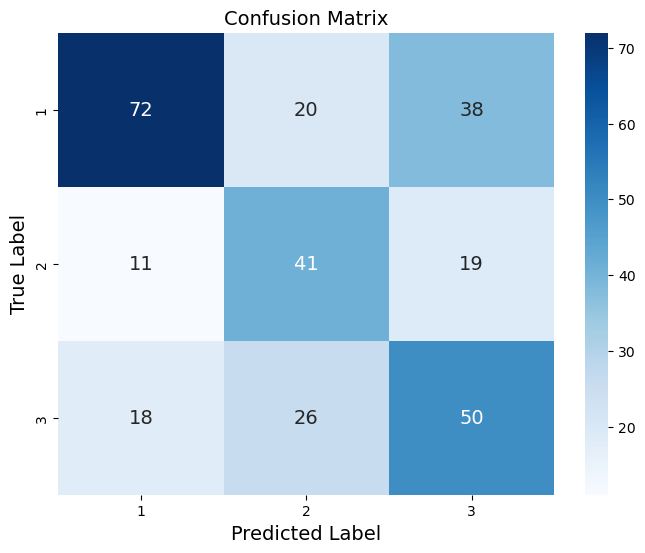

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
5361.86s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
5362.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modu

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix

# Configuración SEGURA para multiclase
logistic_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        random_state=42,
        multi_class='multinomial',
        solver='saga',  
        n_jobs=-1  
    ))
])

# Hiperparámetros 
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['saga', 'lbfgs'],  # Solvers que soportan 'multinomial'
    'classifier__multi_class': ['multinomial', 'ovr'],
    "classifier__class_weight": [None, 'balanced']
    
}


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

grid_search_logistic = GridSearchCV(
    estimator=logistic_model,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1, 
    error_score='raise'
)
grid_search_logistic.fit(X_train, y_train)
best_logistic = grid_search_logistic.best_estimator_
y_pred_logistic = best_logistic.predict(X_test)
print("Best parameters:", grid_search_logistic.best_params_)
print("\nClassification report on test set:")
print(classification_report(y_test, y_pred_logistic))

cm = confusion_matrix(y_test, y_pred_logistic)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["1", "2", "3"], 
            yticklabels=["1", "2", "3"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [92]:
print("Test f1_score:", f1_score(y_test, y_pred_logistic, average='weighted'))

Test f1_score: 0.5581465473186871


In [94]:
# Results from training and testing
# See if there's any overfitting

# Train the model with X_train
best_logistic_predict = best_logistic.predict(X_train)


print("\nClassification report on training set:")
print(classification_report(y_train, best_logistic_predict))

# F1 scores for comparison
train_f1 = f1_score(y_train, best_logistic_predict, average='weighted')
test_f1 = f1_score(y_test, y_pred_logistic, average='weighted')

print(f"Train f1_score: {train_f1}")
print(f"Test  f1_score: {test_f1}")


Classification report on training set:
              precision    recall  f1-score   support

           1       0.66      0.50      0.57       499
           2       0.39      0.60      0.47       262
           3       0.50      0.48      0.49       417

    accuracy                           0.51      1178
   macro avg       0.52      0.53      0.51      1178
weighted avg       0.54      0.51      0.52      1178

Train f1_score: 0.5185172244496669
Test  f1_score: 0.5581465473186871


Unlike the first model built with k-neighbors, this model performed slightly worse in terms of f1 score in all classes, both in training and testing.

So, it turns out that there isn't as strong a linear relationship between the predictors and our final classes (or more so than there would be for other classification models that look for other types of relationships).

As a particular addition, due to the way logistic regression works, the final model is represented as a series of three equations (since there are three targets), making it easy to visualize.

In [95]:

coeficientes = best_logistic.named_steps['classifier'].coef_
interceptos = best_logistic.named_steps['classifier'].intercept_

nombres_features = best_logistic.named_steps['preprocessor'].get_feature_names_out()

print("Ecuaciones de regresión logística (multiclase):\n")
for clase, (intercepto, coefs) in enumerate(zip(interceptos, coeficientes), start=1):
    ecuacion = f"Clase {clase}: log(P(y={clase})/P(y=K)) = {intercepto:.3f}"
    for feature, coef in zip(nombres_features, coefs):
        ecuacion += f" + {coef:.3f}*{feature}"
    print(ecuacion + "\n")

Ecuaciones de regresión logística (multiclase):

Clase 1: log(P(y=1)/P(y=K)) = 0.970 + -0.227*cat__Wifes_education_2 + -0.629*cat__Wifes_education_3 + -1.093*cat__Wifes_education_4 + 0.129*cat__Husbands_occupation_2 + 0.010*cat__Husbands_occupation_3 + -0.297*cat__Husbands_occupation_4 + -0.008*cat__Husbands_education_2 + -0.193*cat__Husbands_education_3 + -0.004*cat__Husbands_education_4 + -0.381*cat__Standard-of-living_index_2 + -0.508*cat__Standard-of-living_index_3 + -0.727*cat__Standard-of-living_index_4 + 0.347*binary__Wifes_religion + -0.022*binary__Wifes_now_working%3F + 0.272*binary__Media_exposure + 0.436*num__Wifes_age + -0.557*num__Number_of_children_ever_born

Clase 2: log(P(y=2)/P(y=K)) = -0.205 + 0.417*cat__Wifes_education_2 + 0.952*cat__Wifes_education_3 + 1.283*cat__Wifes_education_4 + -0.311*cat__Husbands_occupation_2 + -0.260*cat__Husbands_occupation_3 + 0.253*cat__Husbands_occupation_4 + -0.664*cat__Husbands_education_2 + -0.679*cat__Husbands_education_3 + -0.748*ca

In [112]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1178 entries, 998 to 1126
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Wifes_age                     1178 non-null   uint8   
 1   Wifes_education               1178 non-null   category
 2   Husbands_education            1178 non-null   category
 3   Number_of_children_ever_born  1178 non-null   uint8   
 4   Wifes_religion                1178 non-null   category
 5   Wifes_now_working%3F          1178 non-null   category
 6   Husbands_occupation           1178 non-null   category
 7   Standard-of-living_index      1178 non-null   category
 8   Media_exposure                1178 non-null   category
dtypes: category(7), uint8(2)
memory usage: 20.7 KB


In [ ]:
from sklearn.ensemble import VotingClassifier


ensemble = VotingClassifier(
    estimators=[('model1', best_logistic),('model3', best_tree),('model2', best_knn)],
    voting='hard',  
)

ensemble.fit(X_train, y_train)
y_test_pred_ensemble = ensemble.predict(X_test)
y_train_predict_ensemble =  ensemble.predict(X_train)

print(classification_report(y_train,y_train_predict_ensemble))

# F1 scores for comparison
train_f1 = f1_score(y_train, y_train_predict_ensemble, average='weighted')
test_f1 = f1_score(y_test, y_test_pred_ensemble, average='weighted')

print(f"Train f1_score: {train_f1}")
print(f"Test  f1_score: {test_f1}")


/home/santiagonavafigueroa/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.66      0.64      0.65       499
           2       0.50      0.43      0.46       262
           3       0.51      0.58      0.54       417

    accuracy                           0.57      1178
   macro avg       0.56      0.55      0.55      1178
weighted avg       0.57      0.57      0.57      1178

Train f1_score: 0.5699280331216234
Test  f1_score: 0.5951725255517644


# References

GeekforGeeks. (2025, Mayo 14). K-Nearest Neighbor(KNN) Algorithm. https://www.geeksforgeeks.org/machine-learning/k-nearest-neighbours/

IBM. (n.d.). ¿Qué es el algoritmo de k vecinos más cercanos (KNN)? https://www.ibm.com/mx-es/think/topics/knn
